                     R2_CV    RMSE_CV
LinearRegression  0.338800  62.504792
Ridge             0.382059  60.465540
Lasso             0.445447  57.133522
                   R2_Test  RMSE_Test
LinearRegression  0.415640  55.641965
Ridge             0.455779  53.696955
Lasso             0.516080  50.634784


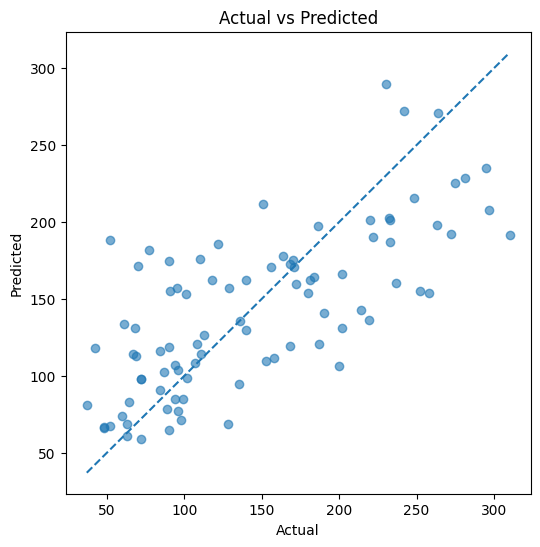

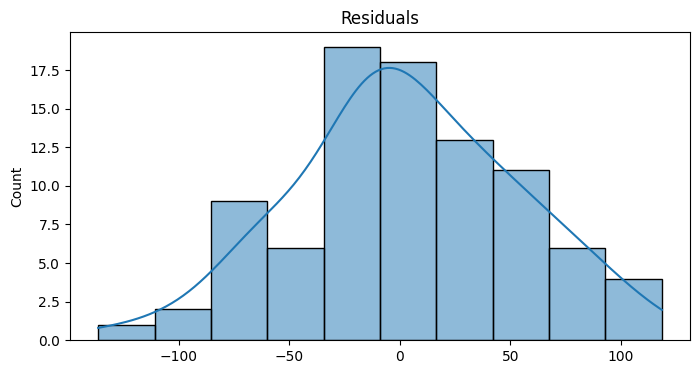

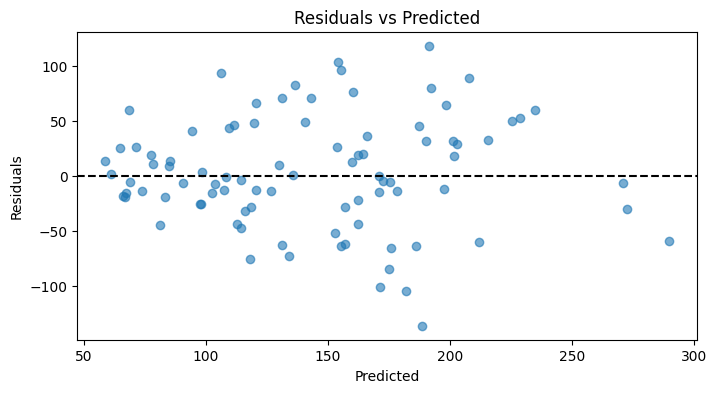

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

numeric_features = X.columns.tolist()

preprocessor = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

models = {
    "LinearRegression": Pipeline([("prep", preprocessor), ("reg", LinearRegression())]),
    "Ridge": Pipeline([("prep", preprocessor), ("reg", Ridge())]),
    "Lasso": Pipeline([("prep", preprocessor), ("reg", Lasso(max_iter=10000))])
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    cv_res = cross_validate(model, X_train, y_train, scoring=["r2","neg_mean_squared_error"], cv=cv)
    mse = -cv_res["test_neg_mean_squared_error"]
    rmse = np.sqrt(mse)
    results[name] = {
        "R2_CV": cv_res["test_r2"].mean(),
        "RMSE_CV": rmse.mean()
    }

print(pd.DataFrame(results).T)

test_results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    pred = model.predict(X_test)
    test_results[name] = {
        "R2_Test": r2_score(y_test, pred),
        "RMSE_Test": np.sqrt(mean_squared_error(y_test, pred))
    }

test_df = pd.DataFrame(test_results).T
print(test_df)

best_model_name = test_df["R2_Test"].idxmax()
best_model = trained_models[best_model_name]

pred = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

residuals = y_test - pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals")
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()
